In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
df_mea = pd.read_sql("SELECT * FROM measurement",engine)
df_mea.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [11]:
df_sta = pd.read_sql("SELECT * FROM station",engine)
df_sta.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12  = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last12

('2017-08-23',)

In [13]:
# Calculate the date 1 year ago from the last data point in the database
from datetime import datetime, timedelta
last_date = datetime.strptime(last12[0],'%Y-%m-%d')
oneyear_ago=last_date - timedelta(days=365)

print("One year ago: ", oneyear_ago)

One year ago:  2016-08-23 00:00:00


In [14]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date>oneyear_ago).\
            order_by(Measurement.date.asc()).all()


In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_mea = pd.DataFrame(results, columns = ['date', 'precipitation'])
df_mea.set_index('date', inplace=True, )
df_mea.head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<AxesSubplot:xlabel='date'>

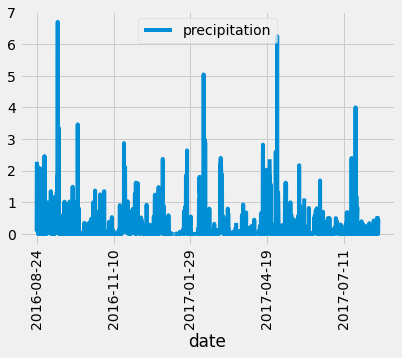

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
df_mea.plot(rot=90)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_mea.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
Num_station = (session.query(func.count(Station.station)).all())[0][0]
Num_station

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first()

('USC00519281', 2772)

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_temp = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281").\
    filter(Measurement.date > oneyear_ago).\
    all()

In [22]:
temp_df = pd.DataFrame(result_temp,  columns = ['tobs'])

<AxesSubplot:ylabel='Frequency'>

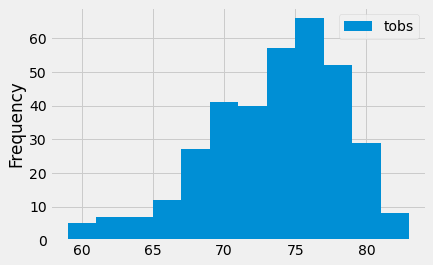

In [23]:
temp_df.plot.hist(bins =12)

## Bonus Challenge Assignment

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
results = calc_temps("2016-06-30", "2016-07-06")
results

[(71.0, 77.125, 82.0)]

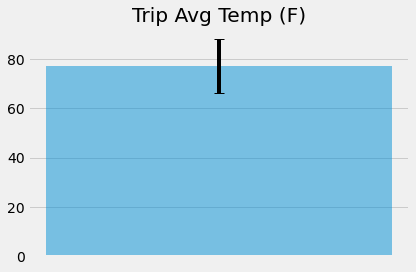

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots()
title = "Trip Avg Temp (F)"
error = results[0][2] - results[0][0]
plt.bar(0, results[0][1], yerr=error, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.title(title)
plt.xticks([],[])
plt.tight_layout()

plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
target = [Measurement.station, Station.name,\
          Station.latitude, Station.longitude,\
          Station.elevation,\
          func.avg(Measurement.prcp)]

results = session.query(*target).\
filter(Measurement.date < "2017-07-06").\
filter(Measurement.date > "2016-06-30").\
group_by(Measurement.station).\
order_by(func.avg(Measurement.prcp).desc()).all()

print(results)


[('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.5071428571428497), ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.25129729729729555), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17094594594594462), ('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.1420312500000001), ('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.13342412451361826), ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08365079365079357), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.06341530054644826)]


<ipython-input-29-83f58372f51b>:8: SAWarning: SELECT statement has a cartesian product between FROM element(s) "measurement" and FROM element "station".  Apply join condition(s) between each element to resolve.
  results = session.query(*target).\


In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
